In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.interpolate
import dask.dataframe as dd

/home/xjin/anaconda3/envs/geo_scipy/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
DIR = '/d3jsb/xjin/Plots/AQI_Evaluation/'
df_CMAQ = pd.read_csv(DIR+'CMAQ_extract_PM_AOD_six_zones_KAPM.csv')
data_merge = pd.read_csv(DIR+'Discover_AQ_data_merge_KAPM.csv')

## AERONET AOD data

In [4]:
DIR = '/d3jsb/xjin/Plots/AOD_Comparison/'
data_aero = pd.read_csv(DIR +'MAIAC_CMAQ_SIP_AERONET_comparison_daily_all_together_NEUS_three_AOD_algorithms_001flex_KAPM_clear_land_adj_winter_filter.csv')
data_aero['lat'] =data_aero['lat'].round(1)

data_aero['lon'] =data_aero['lon'].round(1)

data_aero.loc[data_aero['MAIAC_AOD'] < 0,'MAIAC_AOD'] = np.nan
data_aero.loc[data_aero['AOD_551'] < 0,'AOD_551'] = np.nan

## AQS data

In [5]:
DIR = '/d3jsb/xjin/Plots/AQI_Evaluation/'
data_aqs = pd.read_csv(DIR +'CMAQ_SIP_PM25_001_AQI_comparison_NEUS_88101flex_KAPM_clear_land_adj_winter_filter.csv')
data_aqs['lat'] = data_aqs['lat'].round(1)
data_aqs['lon'] = data_aqs['lon'].round(1)

data_aqs.loc[data_aqs['MAIAC_PM'] < 0,'MAIAC_PM'] = np.nan
data_aqs.loc[data_aqs['MAIAC_PM'] < 0,'MAIAC_PM'] = np.nan

In [6]:
uni_JDAY = data_merge['day'].unique()
zone_arr = np.arange(1,7)
lat_arr = [39.2, 39.5, 39.6, 39.7, 39.4, 39.3]
lon_arr = [-76.6, -76.6, -76.2, -75.8, -76.3, -76.5]

# df_CMAQ['CMAQ_EXT_Aircraft_SULF'] = df_CMAQ.AOT_SULF/df_CMAQ.BOXH*1000.
# df_CMAQ['CMAQ_EXT_Aircraft_OC'] = df_CMAQ.AOT_OC/df_CMAQ.BOXH*1000.
# df_CMAQ['CMAQ_EXT_Aircraft_BC'] = df_CMAQ.AOT_BC/df_CMAQ.BOXH*1000.
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for index, row in data_composite.iterrows():
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index), 'EXTamb'] =row.EXTamb
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index), 'EXTdry'] =row.EXTdry
#             df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index), 'CMAQ_EXT_Aircraft_OC'] = df_CMAQ.AOT_OC/df_CMAQ.CONC_OC*row.OC/df_CMAQ.BOXH*1000.
#             df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index), 'CMAQ_EXT_Aircraft_BC'] = df_CMAQ.AOT_BC/df_CMAQ.CONC_BC*row.BC/df_CMAQ.BOXH*1000.
#         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC


In [7]:
var_arr = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
        for iv in var_arr:
#     data_composite = data_composite.reset_index()
#     alt_uni = data_composite.ind_ALT.unique()
            for index, row in data_composite.iterrows():
                df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['ind_ALT'] == index), 'EXTamb_interp'] = row.EXTamb
                #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['Alt']<= 4)]
#             if not df_judge['CMAQ_EXT_Aircraft_'+iv+'_interp'].isnull().all():
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['Alt']>4), 'EXTamb_interp'] = df_CMAQ['AOT_'+iv]/df_CMAQ.BOXH*1000.
            df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)]
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone), 'EXTamb_interp'] = df_sub['EXTamb_interp'].interpolate(limit_direction = 'both', method = 'linear')
# df_CMAQ['CMAQ_EXT_Aircraft_BC_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_BC_interp'].fillna(0)
# df_CMAQ['CMAQ_EXT_Aircraft_OC_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_OC_interp'].fillna(0)
# df_CMAQ['CMAQ_EXT_Aircraft_SULF_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_interp'].fillna(0)

In [8]:
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
        for iv in var_arr:
#     data_composite = data_composite.reset_index()
#     alt_uni = data_composite.ind_ALT.unique()
            for index, row in data_composite.iterrows():
                df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['ind_ALT'] == index), 'EXTdry_interp'] = row.EXTdry
                #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['Alt']<= 4)]
#             if not df_judge['CMAQ_EXT_Aircraft_'+iv+'_interp'].isnull().all():
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['Alt']>4), 'EXTdry_interp'] = df_CMAQ['AOT_'+iv]/df_CMAQ.BOXH*1000.
            df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)]
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone), 'EXTdry_interp'] = df_sub['EXTdry_interp'].interpolate(limit_direction = 'both', method = 'linear')
# df_CMAQ['CMAQ_EXT_Aircraft_BC_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_BC_interp'].fillna(0)
# df_CMAQ['CMAQ_EXT_Aircraft_OC_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_OC_interp'].fillna(0)
# df_CMAQ['CMAQ_EXT_Aircraft_SULF_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_interp'].fillna(0)

# Change the mass of CMAQ to aircraft mass (keep other layers as the CMAQ value)

In [9]:
df_CMAQ['CMAQ_EXT_Aircraft_SULF_ori'] = df_CMAQ.AOT_SULF/df_CMAQ.BOXH*1000.
df_CMAQ['CMAQ_EXT_Aircraft_OC_ori'] = df_CMAQ.AOT_OC/df_CMAQ.BOXH*1000.
df_CMAQ['CMAQ_EXT_Aircraft_BC_ori'] = df_CMAQ.AOT_BC/df_CMAQ.BOXH*1000.

In [10]:
uni_JDAY = data_merge['day'].unique()
zone_arr = np.arange(1,7)
lat_arr = [39.2, 39.5, 39.6, 39.7, 39.4, 39.3]
lon_arr = [-76.6, -76.6, -76.2, -75.8, -76.3, -76.5]

df_CMAQ['CMAQ_EXT_Aircraft_SULF'] = df_CMAQ.AOT_SULF/df_CMAQ.BOXH*1000.
df_CMAQ['CMAQ_EXT_Aircraft_OC'] = df_CMAQ.AOT_OC/df_CMAQ.BOXH*1000.
df_CMAQ['CMAQ_EXT_Aircraft_BC'] = df_CMAQ.AOT_BC/df_CMAQ.BOXH*1000.
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for index, row in data_composite.iterrows():
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index), 'CMAQ_EXT_Aircraft_SULF'] = df_CMAQ.AOT_SULF/df_CMAQ.CONC_SULF*row.SULF/df_CMAQ.BOXH*1000.
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index), 'CMAQ_EXT_Aircraft_OC'] = df_CMAQ.AOT_OC/df_CMAQ.CONC_OC*row.OC/df_CMAQ.BOXH*1000.
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index), 'CMAQ_EXT_Aircraft_BC'] = df_CMAQ.AOT_BC/df_CMAQ.CONC_BC*row.BC/df_CMAQ.BOXH*1000.
#         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC


In [11]:
df_CMAQ['CMAQ_EXT_Aircraft_Mass'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF'] + df_CMAQ['CMAQ_EXT_Aircraft_OC'] +df_CMAQ['CMAQ_EXT_Aircraft_BC']

In [12]:
df_CMAQ['CMAQ_CONC_Aircraft_SULF'] = df_CMAQ.CONC_SULF
df_CMAQ['CMAQ_CONC_Aircraft_OC'] = df_CMAQ.CONC_OC
df_CMAQ['CMAQ_CONC_Aircraft_BC'] = df_CMAQ.CONC_BC

for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for index, row in data_composite.iterrows():
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['ind_ALT'] == index), 'CMAQ_CONC_Aircraft_SULF'] = row.SULF
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['ind_ALT'] == index), 'CMAQ_CONC_Aircraft_OC'] = row.OC
            df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['ind_ALT'] == index), 'CMAQ_CONC_Aircraft_BC'] = row.BC

# Change the mass of CMAQ to aircraft mass (interpolate the missing values)

In [13]:
var_arr = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
        for iv in var_arr:
#     data_composite = data_composite.reset_index()
#     alt_uni = data_composite.ind_ALT.unique()
            for index, row in data_composite.iterrows():
                df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['ind_ALT'] == index), 'CMAQ_EXT_Aircraft_'+iv+'_interp'] = df_CMAQ['AOT_'+iv]/df_CMAQ['CONC_'+iv]*row[iv]/df_CMAQ.BOXH*1000.
                #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['Alt']<= 4)]
            if not df_judge['CMAQ_EXT_Aircraft_'+iv+'_interp'].isnull().all():
                df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['Alt']>4), 'CMAQ_EXT_Aircraft_'+iv+'_interp'] = df_CMAQ['AOT_'+iv]/df_CMAQ.BOXH*1000.
                df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)]
                df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone), 'CMAQ_EXT_Aircraft_'+iv+'_interp'] = df_sub['CMAQ_EXT_Aircraft_'+iv+'_interp'].interpolate(limit_direction = 'both', method = 'linear')
# df_CMAQ['CMAQ_EXT_Aircraft_BC_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_BC_interp'].fillna(0)
# df_CMAQ['CMAQ_EXT_Aircraft_OC_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_OC_interp'].fillna(0)
# df_CMAQ['CMAQ_EXT_Aircraft_SULF_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_interp'].fillna(0)

In [14]:
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for iv in var_arr:

            for index, row in data_composite.iterrows():
                df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['ind_ALT'] == index), 'CMAQ_CONC_Aircraft_'+iv+'_interp'] =row[iv]
        #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_'+iv+'_factor*data_merge.'+iv+' + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['Alt']<= 4)]
            if not df_judge['CMAQ_CONC_Aircraft_'+iv+'_interp'].isnull().all():
                df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)&  (df_CMAQ['Alt']>=4), 'CMAQ_CONC_Aircraft_'+iv+'_interp'] = df_CMAQ['AOT_'+iv]/df_CMAQ.BOXH*1000.
                df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_Aircraft_'+iv+'_interp'] = df_sub['CMAQ_CONC_Aircraft_'+iv+'_interp'].interpolate(limit_direction = 'both', method = 'linear')
# df_CMAQ['CMAQ_CONC_Aircraft_'+iv+'_interp'] = df_CMAQ['CMAQ_CONC_Aircraft_'+iv+'_interp'].fillna(0)
# df_CMAQ['CMAQ_CONC_Aircraft_OC_interp'] = df_CMAQ['CMAQ_CONC_Aircraft_OC_interp'].fillna(0)
# df_CMAQ['CMAQ_CONC_Aircraft_BC_interp'] = df_CMAQ['CMAQ_CONC_Aircraft_BC_interp'].fillna(0)    

In [15]:
df_CMAQ['CMAQ_CONC_SULF_C'] = df_CMAQ['CONC_SULF']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_OC_C'] = df_CMAQ['CONC_OC']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_BC_C'] = df_CMAQ['CONC_BC']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_TOT_C'] = df_CMAQ['CMAQ_CONC_SULF_C'] + df_CMAQ['CMAQ_CONC_OC_C'] + df_CMAQ['CMAQ_CONC_BC_C']
df_CMAQ['CMAQ_CONC_Aircraft_SULF_interp_C'] = df_CMAQ['CMAQ_CONC_Aircraft_SULF_interp']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_Aircraft_OC_interp_C'] = df_CMAQ['CMAQ_CONC_Aircraft_OC_interp']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_Aircraft_BC_interp_C'] = df_CMAQ['CMAQ_CONC_Aircraft_BC_interp']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_Aircraft_TOT_interp_C'] = df_CMAQ['CMAQ_CONC_Aircraft_SULF_interp_C']+df_CMAQ['CMAQ_CONC_Aircraft_OC_interp_C']+df_CMAQ['CMAQ_CONC_Aircraft_BC_interp_C']

In [16]:
df_CMAQ['CMAQ_CONC_Aircraft_SULF_C'] = df_CMAQ['CMAQ_CONC_Aircraft_SULF']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_Aircraft_OC_C'] = df_CMAQ['CMAQ_CONC_Aircraft_OC']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_Aircraft_BC_C'] = df_CMAQ['CMAQ_CONC_Aircraft_BC']*df_CMAQ['BOXH']
df_CMAQ['CMAQ_CONC_Aircraft_TOT_C'] = df_CMAQ['CMAQ_CONC_Aircraft_SULF_C']+df_CMAQ['CMAQ_CONC_Aircraft_OC_C']+df_CMAQ['CMAQ_CONC_Aircraft_BC_C']

In [17]:
asub = df_CMAQ[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone))]

# Change the vertical distribution of mass, but keep the total column mass constant

In [18]:
var_str = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        for iv in var_str:
            total_mass_aircraft = df_CMAQ.loc[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_Aircraft_'+iv+'_interp_C'].sum()  
            total_mass_CMAQ = df_CMAQ.loc[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_'+iv+'_C'].sum() 
            ratio = total_mass_CMAQ/total_mass_aircraft
            if np.isfinite(ratio):
                df_CMAQ.loc[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_dist'] \
                =  df_CMAQ.loc[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_interp']*ratio

# Change the total column mass of each species, but keep the distribution as CMAQ

In [19]:
var_str = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        for iv in var_str:
            total_mass_aircraft = df_CMAQ.loc[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_Aircraft_'+iv+'_interp_C'].sum()  
            total_mass_CMAQ = df_CMAQ.loc[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_'+iv+'_C'].sum() 
            ratio = total_mass_aircraft/total_mass_CMAQ
            if np.isfinite(ratio):
                df_sub = df_CMAQ[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone))]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_column_mass'] =df_sub['AOT_'+iv]/df_sub['CONC_'+iv]*ratio

In [20]:
var_str = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        for iv in var_str:
            total_mass_aircraft = df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_Aircraft_'+iv+'_C'].sum()  
            total_mass_CMAQ = df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_'+iv+'_C'].sum() 
            ratio = total_mass_aircraft/total_mass_CMAQ
            if np.isfinite(ratio):
                df_sub = df_CMAQ[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone))]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_column_nointerp'] =df_sub['AOT_'+iv]/df_sub['CONC_'+iv]*ratio

# Change the total column mass of all species together, but keep the distribution as CMAQ

In [21]:
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        iv = 'TOT'
        total_mass_aircraft = df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_Aircraft_'+iv+'_interp_C'].sum()  
        total_mass_CMAQ = df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_'+iv+'_C'].sum() 
        ratio = total_mass_aircraft/total_mass_CMAQ
        if np.isfinite(ratio):
            df_sub = df_CMAQ[ ((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone))]
            df_CMAQ.loc[ ((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_TOT_column_mass_TOT'] =df_sub['EXT']*ratio

In [22]:
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        iv = 'TOT'
        total_mass_aircraft = df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_Aircraft_'+iv+'_C'].sum()  
        total_mass_CMAQ = df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_CONC_'+iv+'_C'].sum() 
        ratio = total_mass_aircraft/total_mass_CMAQ
        df_sub = df_CMAQ[((df_CMAQ['day'] == jday) & df_CMAQ['zone'] == izone)]
        df_CMAQ.loc[((df_CMAQ['day'] == jday) & df_CMAQ['zone'] == izone), 'CMAQ_EXT_Aircraft_TOT_column_mass_TOT_nointerp'] =df_sub['EXT']*ratio

# Change the RH to aircraft observed RH 

In [23]:
rh_arr = [20, 40, 50, 60, 70, 80]
RH_array = ['RH20','RH40','RH50','RH60','RH70','RH80']
var_arr = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        uni_hour = data_jday['t_C'].unique()- (jday-1)*24
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for iv in var_arr:
            for index, row in data_composite.iterrows():
                ext_arr = []
                for ir in RH_array:
                    ext_arr.append(row['CMAQ_EXT_'+iv+'_point'+ir])
                df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CMAQ_EXT_Aircraft_'+iv+'_RH'] = np.interp(row.RHamb, rh_arr, ext_arr)
        #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['Alt']<= 4)]
            if not df_judge['CMAQ_CONC_Aircraft_'+iv+'_interp'].isnull().all():
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone) &  (df_CMAQ['Alt']>4)), 'CMAQ_EXT_Aircraft_'+iv+'_RH'] = df_CMAQ['EXT']
                df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_RH'] = df_sub['CMAQ_EXT_Aircraft_'+iv+'_RH'].interpolate(limit_direction = 'both', method = 'linear')

In [24]:
rh_arr = [20, 40, 50, 60, 70, 80]
RH_array = ['RH20','RH40','RH50','RH60','RH70','RH80']
var_arr = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        uni_hour = data_jday['t_C'].unique()- (jday-1)*24
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for iv in var_arr:
            for index, row in data_composite.iterrows():
                ext_arr = []
                for ir in RH_array:
                    ext_arr.append(row['CMAQ_EXT_'+iv+'_point'+ir])
                df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CMAQ_EXT_Aircraft_'+iv+'_RH_noint'] = np.interp(row.RHamb, rh_arr, ext_arr)
        #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)]
            if not df_judge['CMAQ_CONC_Aircraft_'+iv+'_interp'].isnull().all():
                df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_RH_noint'] = df_sub['CMAQ_EXT_Aircraft_'+iv+'_RH_noint'].interpolate(limit_direction = 'both', method = 'linear')

# Change the RH to aircraft observed RHdry 

In [25]:
rh_arr = [20, 40, 50, 60, 70, 80]
RH_array = ['RH20','RH40','RH50','RH60','RH70','RH80']
var_arr = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        uni_hour = data_jday['t_C'].unique()- (jday-1)*24
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for iv in var_arr:
            for index, row in data_composite.iterrows():
                ext_arr = []
                for ir in RH_array:
                    ext_arr.append(row['CMAQ_EXT_'+iv+'_point'+ir])
                df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CMAQ_EXT_Aircraft_'+iv+'_RHdry'] = np.interp(row.RHdry, rh_arr, ext_arr)
        #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone) &  (df_CMAQ['Alt']<= 4)]
            if not df_judge['CMAQ_CONC_Aircraft_'+iv+'_interp'].isnull().all():
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone) &  (df_CMAQ['Alt']>4)), 'CMAQ_EXT_Aircraft_'+iv+'_RHdry'] = df_CMAQ['EXT']
                df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_RHdry'] = df_sub['CMAQ_EXT_Aircraft_'+iv+'_RHdry'].interpolate(limit_direction = 'both', method = 'linear')

In [26]:
rh_arr = [20, 40, 50, 60, 70, 80]
RH_array = ['RH20','RH40','RH50','RH60','RH70','RH80']
var_arr = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        uni_hour = data_jday['t_C'].unique()- (jday-1)*24
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for iv in var_arr:
            for index, row in data_composite.iterrows():
                ext_arr = []
                for ir in RH_array:
                    ext_arr.append(row['CMAQ_EXT_'+iv+'_point'+ir])
                df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CMAQ_EXT_Aircraft_'+iv+'_RHdry_noint'] = np.interp(row.RHdry, rh_arr, ext_arr)
        #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)]
            if not df_judge['CMAQ_CONC_Aircraft_'+iv+'_interp'].isnull().all():
                df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_RHdry_noint'] = df_sub['CMAQ_EXT_Aircraft_'+iv+'_RHdry_noint'].interpolate(limit_direction = 'both', method = 'linear')

# Change the RHdry and Mass to aircraft observed RHdry/Mass

In [27]:
rh_arr = [20, 40, 50, 60, 70, 80]
RH_array = ['RH20','RH40','RH50','RH60','RH70','RH80']
var_arr = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        uni_hour = data_jday['t_C'].unique()- (jday-1)*24
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for iv in var_arr:
            for index, row in data_composite.iterrows():
                ext_arr = []
                for ir in RH_array:
                    ext_arr.append(row['CMAQ_EXT_'+iv+'_point'+ir])
                conc_a = df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CONC_'+iv]
                con_obs = df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CMAQ_CONC_Aircraft_'+iv+'_interp']
                df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CMAQ_EXT_Aircraft_'+iv+'_RHdry_Mass'] = np.interp(row.RHdry, rh_arr, ext_arr)/conc_a*con_obs
        #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)]
            if not df_judge['CMAQ_CONC_Aircraft_'+iv+'_interp'].isnull().all():
                df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_RHdry_Mass'] = df_sub['CMAQ_EXT_Aircraft_'+iv+'_RHdry_Mass'].interpolate(limit_direction = 'both', method = 'linear')

# Change the RHamb and Mass to aircraft observed RHdamb/Mass

In [28]:
rh_arr = [20, 40, 50, 60, 70, 80]
RH_array = ['RH20','RH40','RH50','RH60','RH70','RH80']
var_arr = ['SULF','OC','BC']
for jday in uni_JDAY:
    for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
        uni_hour = data_jday['t_C'].unique()- (jday-1)*24
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
    #     data_composite = data_composite.reset_index()
    #     alt_uni = data_composite.ind_ALT.unique()
        for iv in var_arr:
            for index, row in data_composite.iterrows():
                ext_arr = []
                for ir in RH_array:
                    ext_arr.append(row['CMAQ_EXT_'+iv+'_point'+ir])
                conc_a = df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CONC_'+iv]
                con_obs = df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CMAQ_CONC_Aircraft_'+iv+'_interp']
                df_CMAQ.loc[((df_CMAQ['day'] == jday)& (df_CMAQ['zone'] == izone) &  (df_CMAQ['ind_ALT'] == index)), 'CMAQ_EXT_Aircraft_'+iv+'_RH_Mass'] = np.interp(row.RHamb, rh_arr, ext_arr)/conc_a*con_obs
        #         df_CMAQ['CMAQ_EXT_Aircraft_Mass'][index] = df_CMAQ.CMAQ_EXT_SULF_factor*data_merge.SULF + data_merge.CMAQ_EXT_OC_factor*data_merge.OC + data_merge.CMAQ_EXT_BC_factor*data_merge.BC
            df_judge = df_CMAQ.loc[(df_CMAQ['day'] == jday) &  (df_CMAQ['zone'] == izone)]
            if not df_judge['CMAQ_CONC_Aircraft_'+iv+'_interp'].isnull().all():
                df_sub = df_CMAQ.loc[(df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)]
                df_CMAQ.loc[((df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)), 'CMAQ_EXT_Aircraft_'+iv+'_RH_Mass'] = df_sub['CMAQ_EXT_Aircraft_'+iv+'_RH_Mass'].interpolate(limit_direction = 'both', method = 'linear')

In [29]:
df_CMAQ['CMAQ_EXT_Aircraft_TOT_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_interp']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_interp'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_interp']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_dist'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_dist']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_dist'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_dist']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_column_mass'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_column_mass']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_column_mass'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_column_mass']
# df_CMAQ['CMAQ_EXT_Aircraft_TOT_column_mass_TOT'] = 
df_CMAQ['CMAQ_EXT_Aircraft_TOT_RH_noint'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_RH_noint']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_RH_noint'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_RH_noint']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_column_nointerp'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_column_nointerp']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_column_nointerp'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_column_nointerp']

In [30]:
df_CMAQ['CMAQ_EXT_Aircraft_TOT_SULF_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_interp']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_SULF_dist'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_dist']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_SULF_column_mass'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_column_mass']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']
# df_CMAQ['CMAQ_EXT_Aircraft_TOT_column_mass_TOT'] = 
df_CMAQ['CMAQ_EXT_Aircraft_TOT_SULF_RH_noint'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_RH_noint']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_SULF_column_nointerp'] = df_CMAQ['CMAQ_EXT_Aircraft_SULF_column_nointerp']+ df_CMAQ['CMAQ_EXT_Aircraft_OC_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']

In [31]:
df_CMAQ['CMAQ_EXT_Aircraft_TOT_OC_interp'] = df_CMAQ['CMAQ_EXT_Aircraft_OC_interp']+ df_CMAQ['CMAQ_EXT_Aircraft_SULF_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_OC_dist'] = df_CMAQ['CMAQ_EXT_Aircraft_OC_dist']+ df_CMAQ['CMAQ_EXT_Aircraft_SULF_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_OC_column_mass'] = df_CMAQ['CMAQ_EXT_Aircraft_OC_column_mass']+ df_CMAQ['CMAQ_EXT_Aircraft_SULF_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']
# df_CMAQ['CMAQ_EXT_Aircraft_TOT_column_mass_TOT'] = 
df_CMAQ['CMAQ_EXT_Aircraft_TOT_OC_RH_noint'] = df_CMAQ['CMAQ_EXT_Aircraft_OC_RH_noint']+ df_CMAQ['CMAQ_EXT_Aircraft_SULF_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']
df_CMAQ['CMAQ_EXT_Aircraft_TOT_OC_column_nointerp'] = df_CMAQ['CMAQ_EXT_Aircraft_OC_column_nointerp']+ df_CMAQ['CMAQ_EXT_Aircraft_SULF_ori'] +df_CMAQ['CMAQ_EXT_Aircraft_BC_ori']

In [32]:
df_CMAQ['CMAQ_CONC_Aircraft_TOT_interp'] = df_CMAQ['CMAQ_CONC_Aircraft_SULF_interp']+df_CMAQ['CMAQ_CONC_Aircraft_OC_interp']+df_CMAQ['CMAQ_CONC_Aircraft_BC_interp']

In [33]:
df_CMAQ['CONC_TOT'] = df_CMAQ['CONC_BC'] + df_CMAQ['CONC_SULF'] + df_CMAQ['CONC_OC'] + df_CMAQ['CONC_SSA']+ df_CMAQ['CONC_DUST']

In [34]:
df_CMAQ['CMAQ_ext_Aircraft_MEE_amb'] = df_CMAQ['EXTamb_interp'] / df_CMAQ['CMAQ_CONC_Aircraft_TOT_interp'] * df_CMAQ['CONC_TOT']
df_CMAQ['CMAQ_ext_Aircraft_MEE_dry'] = df_CMAQ['EXTdry_interp'] / df_CMAQ['CMAQ_CONC_Aircraft_TOT_interp'] * df_CMAQ['CONC_TOT']

In [35]:
import read_CMAQ

In [36]:
df_CMAQ.columns

Index(['Unnamed: 0', 'Alt', 'BOXH', 'EXT', 'EXT_HGF', 'EXT_KAPM', 'RH', 'day',
       'ind_ALT', 'lat',
       ...
       'CMAQ_EXT_Aircraft_TOT_SULF_column_nointerp',
       'CMAQ_EXT_Aircraft_TOT_OC_interp', 'CMAQ_EXT_Aircraft_TOT_OC_dist',
       'CMAQ_EXT_Aircraft_TOT_OC_column_mass',
       'CMAQ_EXT_Aircraft_TOT_OC_RH_noint',
       'CMAQ_EXT_Aircraft_TOT_OC_column_nointerp',
       'CMAQ_CONC_Aircraft_TOT_interp', 'CONC_TOT',
       'CMAQ_ext_Aircraft_MEE_amb', 'CMAQ_ext_Aircraft_MEE_dry'],
      dtype='object', length=146)

In [37]:
def calculate_pm(pm_CMAQ, area, avg_MAIAC):
    pm = pm_CMAQ/area*avg_MAIAC
    return pm

In [38]:
def calculate_aod(ext, boxh, interp = False):
    if interp:
        ext = ext.interpolate(limit_direction = 'both')
#     boxh_2 = boxh[boxh<4000]
#     print(ext[boxh<4000])
    AOD_layer = ext*boxh/1000.
    AOD_sum = AOD_layer.sum()
    return AOD_sum

In [39]:
uni_JDAY

array([ 2,  3,  6, 11, 12, 15, 17, 21, 22, 23, 27, 28, 29, 30])

In [40]:
uni_JDAY = data_merge['day'].unique()
label_arr = ['Mass','SULF','OC','Mass_Inter','SULF_Inter','OC_Inter','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE']
var_str_CMAQ = ['CMAQ_EXT_Aircraft_TOT_interp','CMAQ_EXT_Aircraft_TOT_SULF_interp'\
                ,'CMAQ_EXT_Aircraft_TOT_OC_interp','CMAQ_EXT_Aircraft_TOT_column_mass_TOT','CMAQ_EXT_Aircraft_TOT_SULF_column_mass','CMAQ_EXT_Aircraft_TOT_OC_column_mass',\
                'CMAQ_EXT_Aircraft_TOT_dist','CMAQ_EXT_Aircraft_TOT_SULF_dist','CMAQ_EXT_Aircraft_TOT_OC_dist',\
                'CMAQ_EXT_Aircraft_TOT_RH_noint','CMAQ_EXT_Aircraft_TOT_SULF_RH_noint','CMAQ_EXT_Aircraft_TOT_OC_RH_noint',\
                'CMAQ_ext_Aircraft_MEE_amb']

#'CMAQ_EXT_Aircraft_Mass','CMAQ_EXT_Aircraft_TOT_SULF','CMAQ_EXT_Aircraft_TOT_OC',
aod_cmaq_all = []
pm_cmaq_all = []
day_label = []
zone_label = []
lat_label = []
lon_label = []
pm_aod_all = []

for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
    for jday in uni_JDAY:
        day_label.append(jday)
        zone_label.append(izone)
        lat_label.append(ilat)
        lon_label.append(ilon)
        data_jday = data_merge[(data_merge['day'] == jday) & (data_merge['zone'] == izone)]
        uni_hour = data_jday['t_C'].unique()- (jday-1)*24
        lat_site = ilat
        lon_site = ilon
        uni_level = data_jday['ind_ALT'].unique()

        lat_aqs =  data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                               & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                              ].lat.mean()
        lon_aqs =  data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                               & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                              ].lon.mean()
        pm_aqs = data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                               & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                              ].AQS_PM.mean()
        pm_MAIAC = data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                               & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                              ].MAIAC_PM.mean()
        pm_CMAQ = data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                               & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                              ].CMAQ_PM.mean()
        avg_aero = data_aero.loc[(data_aero.day == jday) & (data_aero.month == 7) \
                               & (abs(data_aero.lat- lat_aqs) < 0.2)  & (abs(data_aero.lon- lon_aqs) < 0.2)\
                              ].AOD_551.mean()
        avg_MAIAC = data_aero.loc[(data_aero.day == jday) & (data_aero.month == 7) \
                               & (abs(data_aero.lat- lat_aqs) < 0.2)  & (abs(data_aero.lon- lon_aqs) < 0.2)\
                              ].MAIAC_AOD.mean()
        avg_CMAQ = data_aero.loc[(data_aero.day == jday) & (data_aero.month == 7) \
                               & (abs(data_aero.lat- lat_aqs) < 0.2)  & (abs(data_aero.lon- lon_aqs) < 0.2)\
                              ].CMAQ_AOD.mean()
        pm_obs_rel = avg_MAIAC*pm_aqs/avg_aero
        pm_aod_obs = pm_aqs/avg_aero
        pm_aod_cmaq = pm_CMAQ/avg_CMAQ

    #     print(avg_aqs)
        data_composite = data_jday.groupby(['ind_ALT']).mean()  
        data_composite = data_composite.reset_index()
    #     ax.plot(data_composite['CMAQ_EXT_point_x'], data_composite['ALTP_x'],label = 'CMAQ', c = 'red', linestyle='--')

        df_CMAQ_sub = df_CMAQ[(df_CMAQ['day'] == jday) & (df_CMAQ['zone'] == izone)]
#         conc_point = 
        #plot of AOD bar charts
        aod_array = [avg_aero,avg_MAIAC,avg_CMAQ]
        aod_cmaq = [avg_aero]
        cmaq_arr = ['EXT','EXT_HGF','EXT_KAPM']
        cmaq_all = [*cmaq_arr, *var_str_CMAQ]
#         aod_sen = [calculate_aod(df_CMAQ_sub[item], df_CMAQ_sub['BOXH']) for item in var_str_CMAQ]
        for icmaq in cmaq_all:
            aod_cmaq.append(calculate_aod(df_CMAQ_sub[icmaq], df_CMAQ_sub['BOXH']))
        join_aod_array = [*aod_array, *aod_cmaq]
        aod_cmaq_all.append(join_aod_array)
        pm_array = [pm_aqs,pm_MAIAC,pm_CMAQ,pm_obs_rel]
        pm_sen = [calculate_pm(pm_CMAQ, item, avg_MAIAC) for item in aod_cmaq]
        join_pm_array = [*pm_array, *pm_sen]
        pm_cmaq_all.append(join_pm_array)
        pm_aod_array = [pm_aod_obs,pm_aod_cmaq]
        pm_aod_sen = [pm_CMAQ/ia for ia in aod_cmaq]
        join_pm_aod_array = [*pm_aod_array, *pm_aod_sen]
        pm_aod_all.append(join_pm_aod_array)
        label_pm_aod_array = ('Obs','model','AERONET','CMAQ','HGF','KAPM','Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE')
        label_aod_array = ['AERONET', 'MAIAC', 'CMAQ_o','AERONET2','CMAQ','HGF','KAPM','Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE']
        label_pm_array = ['AQS', 'MAIAC', 'CMAQ_o','Rel','AERONET','CMAQ','HGF','KAPM','Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE']

In [41]:
df_aod_all = pd.DataFrame.from_records(aod_cmaq_all, columns=label_aod_array)
df_pm_all = pd.DataFrame.from_records(pm_cmaq_all, columns=label_pm_array)
df_pm_aod_all = pd.DataFrame.from_records(pm_aod_all, columns=label_pm_aod_array)
df_aod_all['Day'] = day_label
df_pm_all['Day'] = day_label
df_pm_aod_all['Day'] = day_label
df_aod_all['lat'] = lat_label
df_pm_all['lat'] = lat_label
df_pm_aod_all['lat'] = lat_label
df_aod_all['lon'] = lon_label
df_pm_all['lon'] = lon_label
df_pm_aod_all['lon'] = lon_label
df_aod_all['zone'] = zone_label
df_pm_all['zone'] = zone_label
df_pm_aod_all['zone'] = zone_label
df_aod_all = df_aod_all.sort_values(by=['Day'])
df_pm_all = df_pm_all.sort_values(by=['Day'])
df_pm_aod_all = df_pm_aod_all.sort_values(by=['Day'])

In [42]:
# df_pm_all = df_pm_all.dropna(subset=['Mass','Column_TOT','Profile'])
# df_aod_all = df_aod_all.dropna(subset=['Mass','Column_TOT','Profile'])
# df_pm_aod_all = df_pm_aod_all.dropna(subset=['Mass','Column_TOT','Profile'])

In [43]:
df_pm_all.to_csv(DIR+'Discover_AQ_data_df_pm_all_species.csv')
df_aod_all.to_csv(DIR+'Discover_AQ_data_df_aod_all_species.csv')
df_pm_aod_all.to_csv(DIR+'Discover_AQ_data_df_pm_aod_all_species.csv')

In [44]:
var_name = ['Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE','AQS']
for iv in var_name:
    df_pm_all[iv+'dif'] = df_pm_all['MAIAC'] - df_pm_all[iv]

In [45]:
var_name = ['Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE','CMAQ','Obs']
for iv in var_name:
    df_pm_aod_all[iv+'dif'] = df_pm_aod_all[iv] - df_pm_aod_all['CMAQ']

In [46]:
df_aod_all['MAIAC_Rel'] = df_pm_all['CMAQ']/df_aod_all['CMAQ']
df_aod_all['MAIAC_Rel_ratio'] = df_aod_all['MAIAC_Rel']/(df_pm_all['AQS']/df_aod_all['AERONET'])
df_aod_all['Rel_Obs'] = df_aod_all['MAIAC']*(df_pm_all['AQS']/df_aod_all['AERONET'])
df_pm_all['Rel_Obsdif'] = (df_pm_all['AQS']/df_aod_all['AERONET'] - df_pm_all['CMAQ']/df_aod_all['CMAQ'])*(df_aod_all['MAIAC'])

In [47]:
uni_JDAY = data_merge['day'].unique()
label_arr = ['Mass','SULF','OC','Mass_Inter','SULF_Inter','OC_Inter','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE']
var_str_CMAQ = ['CMAQ_EXT_Aircraft_TOT_interp','CMAQ_EXT_Aircraft_TOT_SULF_interp'\
                ,'CMAQ_EXT_Aircraft_TOT_OC_interp','CMAQ_EXT_Aircraft_TOT_column_mass_TOT','CMAQ_EXT_Aircraft_TOT_SULF_column_mass','CMAQ_EXT_Aircraft_TOT_OC_column_mass',\
                'CMAQ_EXT_Aircraft_TOT_dist','CMAQ_EXT_Aircraft_TOT_SULF_dist','CMAQ_EXT_Aircraft_TOT_OC_dist',\
                'CMAQ_EXT_Aircraft_TOT_RH_noint','CMAQ_EXT_Aircraft_TOT_SULF_RH_noint','CMAQ_EXT_Aircraft_TOT_OC_RH_noint',\
                'CMAQ_ext_Aircraft_MEE_amb']

#'CMAQ_EXT_Aircraft_Mass','CMAQ_EXT_Aircraft_TOT_SULF','CMAQ_EXT_Aircraft_TOT_OC',
aod_cmaq_day = []
pm_cmaq_day = []
day_label = []
# zone_label = []
# lat_label = []
# lon_label = []
pm_aod_day = []

# for izone,ilat,ilon in zip(zone_arr,lat_arr,lon_arr):
for jday in uni_JDAY:
    day_label.append(jday)
#     zone_label.append(izone)
#     lat_label.append(ilat)
#     lon_label.append(ilon)
    data_jday = data_merge[(data_merge['day'] == jday) ]
    uni_hour = data_jday['t_C'].unique()- (jday-1)*24
    lat_site = ilat
    lon_site = ilon
    uni_level = data_jday['ind_ALT'].unique()

    lat_aqs =  data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                           & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                          ].lat.mean()
    lon_aqs =  data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                           & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                          ].lon.mean()
    pm_aqs = data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                           & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                          ].AQS_PM.mean()
    pm_MAIAC = data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                           & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                          ].MAIAC_PM.mean()
    pm_CMAQ = data_aqs.loc[(data_aqs.day == jday) & (data_aqs.month == 7) \
                           & (abs(data_aqs.lat- lat_site) < 0.4)  & (abs(data_aqs.lon- lon_site) < 0.4)\
                          ].CMAQ_PM.mean()
    avg_aero = data_aero.loc[(data_aero.day == jday) & (data_aero.month == 7) \
                           & (abs(data_aero.lat- lat_aqs) < 0.2)  & (abs(data_aero.lon- lon_aqs) < 0.2)\
                          ].AOD_551.mean()
    avg_MAIAC = data_aero.loc[(data_aero.day == jday) & (data_aero.month == 7) \
                           & (abs(data_aero.lat- lat_aqs) < 0.2)  & (abs(data_aero.lon- lon_aqs) < 0.2)\
                          ].MAIAC_AOD.mean()
    avg_CMAQ = data_aero.loc[(data_aero.day == jday) & (data_aero.month == 7) \
                           & (abs(data_aero.lat- lat_aqs) < 0.2)  & (abs(data_aero.lon- lon_aqs) < 0.2)\
                          ].CMAQ_AOD.mean()
    pm_obs_rel = avg_MAIAC*pm_aqs/avg_aero
    pm_aod_obs = pm_aqs/avg_aero
    pm_aod_cmaq = pm_CMAQ/avg_CMAQ

#     print(avg_aqs)
    data_composite = data_jday.groupby(['ind_ALT']).mean()  
    data_composite = data_composite.reset_index()
#     ax.plot(data_composite['CMAQ_EXT_point_x'], data_composite['ALTP_x'],label = 'CMAQ', c = 'red', linestyle='--')

    df_CMAQ_sub = df_CMAQ[(df_CMAQ['day'] == jday)]
#         conc_point = 
    #plot of AOD bar charts
    aod_array = [avg_aero,avg_MAIAC,avg_CMAQ]
    aod_cmaq = [avg_aero]
    cmaq_arr = ['EXT','EXT_HGF','EXT_KAPM']
    cmaq_day = [*cmaq_arr, *var_str_CMAQ]
#         aod_sen = [calculate_aod(df_CMAQ_sub[item], df_CMAQ_sub['BOXH']) for item in var_str_CMAQ]
    for icmaq in cmaq_day:
        aod_cmaq.append(calculate_aod(df_CMAQ_sub[icmaq], df_CMAQ_sub['BOXH']))
    join_aod_array = [*aod_array, *aod_cmaq]
    aod_cmaq_day.append(join_aod_array)
    pm_array = [pm_aqs,pm_MAIAC,pm_CMAQ,pm_obs_rel]
    pm_sen = [calculate_pm(pm_CMAQ, item, avg_MAIAC) for item in aod_cmaq]
    join_pm_array = [*pm_array, *pm_sen]
    pm_cmaq_day.append(join_pm_array)
    pm_aod_array = [pm_aod_obs,pm_aod_cmaq]
    pm_aod_sen = [pm_CMAQ/ia for ia in aod_cmaq]
    join_pm_aod_array = [*pm_aod_array, *pm_aod_sen]
    pm_aod_day.append(join_pm_aod_array)
    label_pm_aod_array = ('Obs','model','AERONET','CMAQ','HGF','KAPM','Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE')
    label_aod_array = ['AERONET', 'MAIAC', 'CMAQ_o','AERONET2','CMAQ','HGF','KAPM','Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE']
    label_pm_array = ['AQS', 'MAIAC', 'CMAQ_o','Rel','AERONET','CMAQ','HGF','KAPM','Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE']

In [48]:
df_aod_day = pd.DataFrame.from_records(aod_cmaq_day, columns=label_aod_array)
df_pm_day = pd.DataFrame.from_records(pm_cmaq_day, columns=label_pm_array)
df_pm_aod_day = pd.DataFrame.from_records(pm_aod_day, columns=label_pm_aod_array)
df_aod_day['Day'] = day_label
df_pm_day['Day'] = day_label
df_pm_aod_day['Day'] = day_label
df_aod_day = df_aod_day.sort_values(by=['Day'])
df_pm_day = df_pm_day.sort_values(by=['Day'])
df_pm_aod_day = df_pm_aod_day.sort_values(by=['Day'])

In [49]:
df_aod_day = df_aod_all.groupby('Day').mean()
df_pm_day = df_pm_all.groupby('Day').mean()

In [50]:
df_pm_aod_all= df_pm_aod_all.dropna(subset=['Obs'])

In [51]:
df_pm_day = df_pm_day.reset_index()

Text(0.96,0.95,'All')

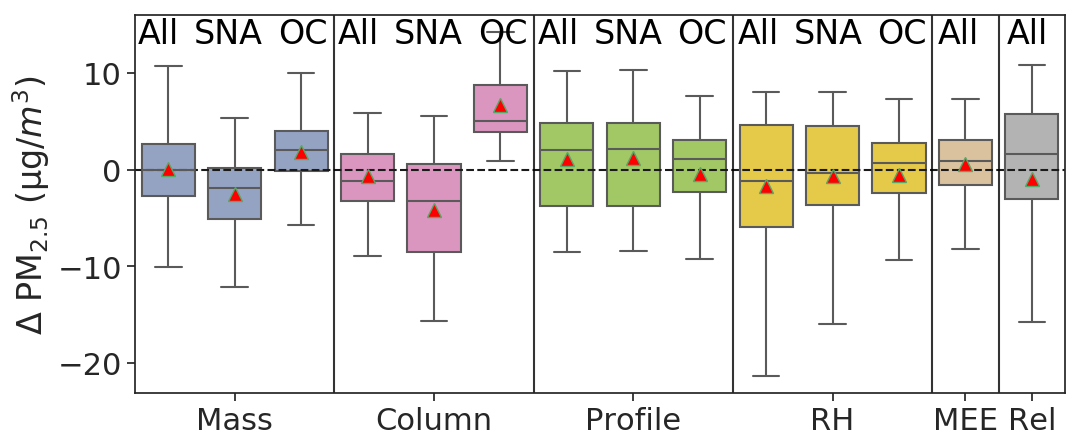

In [52]:
mylist = ['Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE']
var_name = [s + 'dif' for s in mylist]
var_name.append('Rel_Obsdif')
var_name2 = [s + 'dif' for s in mylist]
var_name2.append('Rel_Obsdif')
var_name.append('Day')
df = df_pm_all[abs(df_pm_all['Rel_Obsdif']) < 30][var_name]
# var_name = [var_name, 'Day']

# var_name = ['Massdif','Columndif','Distributiondif','MEEdif','RHdif','Rel_Obsdif','Day']
# df = df.rename(columns = {'Massdif':'Mass','Columndif':'Column','Distributiondif':'Profile','MEEdif':'MEE','RHdif':'RH','Rel_Obsdif':'PM$_{2.5}$/AOD','Day':'Day'})
sns.set(color_codes=True, font_scale = 2)
color_arr = sns.color_palette("Set2", 8)
color_arr_sub = color_arr[2:8]
color_arr_all = []
for iv in color_arr_sub[0:4]:
    for ic in range(0,3):
        color_arr_all.append(iv)
color_arr_all.append(color_arr[6])
color_arr_all.append(color_arr[7])
meanpointprops = dict( markerfacecolor='red', markersize=10)


tidy_PM = (
    df.set_index('Day')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

# df_pm_all[var_name].boxplot()
sns.set(color_codes=True, font_scale = 2)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
fig, ax = plt.subplots(figsize=(12, 5), dpi = 100)
# ax = axarr[0]
sns.boxplot(x = 'Variable', y = 'Value',  data =tidy_PM,  ax = ax, palette = color_arr_all, showmeans = True, showfliers=False, meanprops = meanpointprops, order = var_name2)
ax.axhline(0, color='k',linestyle = '--',linewidth = 1.5)

ax.set_xlabel('');
ax.set_ylabel('$\Delta$ PM$_{2.5}$ (µg/$m^3$)');
ax.set_title('');
ax.axvline(12.5, color='black',alpha = 0.8)
ax.axvline(11.5, color='black',alpha = 0.8)
ax.axvline(8.5, color='black',alpha = 0.8)
ax.axvline(5.5, color='black',alpha = 0.8)
ax.axvline(2.5, color='black',alpha = 0.8)


x = [1, 4, 7, 10, 12, 13]
labels = ['Mass', 'Column','Profile','RH','MEE','Rel']

plt.xticks(x, labels)

ax.tick_params(which='minor', length=4, color='r')

for i in range(0,4):
    ax.text(0.025+i*0.215, 0.95,'All', ha='center', va='center', transform=ax.transAxes, color = 'black')
    ax.text(0.100+i*0.215, 0.95,'SNA', ha='center', va='center', transform=ax.transAxes, color = 'black')
    ax.text(0.180+i*0.215, 0.95,'OC', ha='center', va='center', transform=ax.transAxes, color = 'black')

ax.text(0.025+4*0.215, 0.95,'All', ha='center', va='center', transform=ax.transAxes, color = 'black')
ax.text(0.1+4*0.215, 0.95,'All', ha='center', va='center', transform=ax.transAxes, color = 'black')

# for tick in ax.get_xticklabels():
#     tick.set_rotation(90)
    
# var_name = ['Column_Rel_ratio','Distribution_Rel_ratio','MEE_Rel_ratio','RH_Rel_ratio','Day']
# df = df_aod_all[var_name]
# df = df.rename(columns = {'Column_Rel_ratio':'Column','Distribution_Rel_ratio':'Profile','MEE_Rel_ratio':'MEE','RH_Rel_ratio':'RH','Day':'Day'})

# tidy_AOD = (
#     df.set_index('Day')
#       .stack()  # un-pivots the data 
#       .reset_index()  # moves all data out of the index
#       .rename(columns={'level_1': 'Variable', 0: 'Value'})
# )
# ax.yaxis.tick_right()
# ax.set_aspect('auto')
# ax.yaxis.set_label_position('right')



In [53]:
df.describe()

,Massdif,SULFdif,OCdif,Column_TOTdif,Column_SULFdif,Column_OCdif,Profiledif,Profile_SULFdif,Profile_OCdif,RHdif,RH_SULFdif,RH_OCdif,MEEdif,Rel_Obsdif,Day
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,44.000000,44.000000
mean,0.051794,-2.485840,1.877192,-0.666660,-4.116289,6.670771,1.088918,1.175256,-0.483648,-1.680099,-0.669484,-0.563436,0.629787,-0.911979,19.840909
std,4.377605,4.735540,4.254039,3.650509,5.580764,4.375805,4.958891,4.954129,5.143396,7.472684,6.605070,5.027154,4.283625,9.796628,7.168871
min,-10.026508,-19.852705,-8.199487,-8.898468,-15.640392,0.868695,-8.503861,-8.406419,-12.220950,-21.305748,-19.154120,-13.003695,-12.274330,-29.502141,3.000000
25%,-2.718123,-5.114215,-0.168307,-3.202533,-8.550608,3.888103,-3.699207,-3.694131,-2.347624,-5.895918,-3.692560,-2.431868,-1.556913,-3.020293,14.250000
50%,0.032448,-1.902515,2.003690,-1.138298,-3.224275,5.049247,2.015306,2.105681,1.080151,-1.205110,-0.321499,0.743328,0.866599,1.612724,21.500000
75%,2.704892,0.165668,3.974495,1.612281,0.642091,8.751535,4.849263,4.877155,3.068478,4.664865,4.582404,2.790243,3.053894,5.792926,27.000000
max,10.778479,5.394481,12.361671,9.443009,5.599268,22.144107,10.232847,10.304719,7.620833,8.059904,8.046385,7.328316,11.048786,10.872469,30.000000


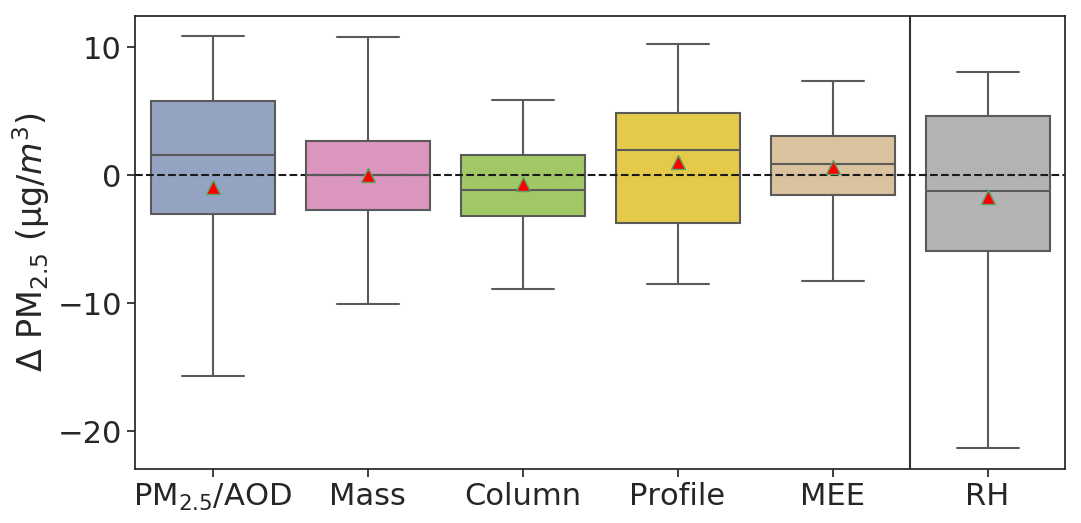

In [54]:
var_name = ['Massdif','Column_TOTdif','Profiledif','MEEdif','RHdif','Rel_Obsdif','Day']
df_sub = df_pm_all[(df_pm_all['Rel_Obsdif'] < 30) & (df_pm_all['Rel_Obsdif'] > -30)][var_name]
df = df_sub[var_name]
df = df.rename(columns = {'Massdif':'Mass','Column_TOTdif':'Column','Profiledif':'Profile','MEEdif':'MEE','RHdif':'RH','Rel_Obsdif':'PM$_{2.5}$/AOD','Day':'Day'})
sns.set(color_codes=True, font_scale = 2)
color_arr = sns.color_palette("Set2", 8)
color_arr_sub = color_arr[2:8]
meanpointprops = dict( markerfacecolor='red', markersize=10)


tidy_PM = (
    df.set_index('Day')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)

# df_pm_all[var_name].boxplot()
sns.set(color_codes=True, font_scale = 2)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
fig, ax = plt.subplots(figsize=(12, 6), dpi = 100)
# ax = axarr[0]
sns.boxplot(x = 'Variable', y = 'Value', data =tidy_PM,  ax = ax, palette = color_arr_sub, showmeans = True, showfliers=False, meanprops = meanpointprops)
ax.axhline(0, color='k',linestyle = '--',linewidth = 1.5)

ax.set_xlabel('');
ax.set_ylabel('$\Delta$ PM$_{2.5}$ (µg/$m^3$)');
ax.set_title('');
ax.axvline(4.5, color='black',alpha = 0.8)


for tick in ax.get_xticklabels():
    tick.set_rotation(0)
    
# var_name = ['Column_Rel_ratio','Distribution_Rel_ratio','MEE_Rel_ratio','RH_Rel_ratio','Day']
# df = df_aod_all[var_name]
# df = df.rename(columns = {'Column_Rel_ratio':'Column','Distribution_Rel_ratio':'Profile','MEE_Rel_ratio':'MEE','RH_Rel_ratio':'RH','Day':'Day'})

# tidy_AOD = (
#     df.set_index('Day')
#       .stack()  # un-pivots the data 
#       .reset_index()  # moves all data out of the index
#       .rename(columns={'level_1': 'Variable', 0: 'Value'})
# )
# ax.yaxis.tick_right()
# ax.set_aspect('auto')
# ax.yaxis.set_label_position('right')



In [55]:
var_name = ['Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE','Obs']
for iv in var_name:
    df_pm_aod_all[iv+'dif'] = df_pm_aod_all[iv] -  df_pm_aod_all['CMAQ']

In [56]:
df_pm_aod_all= df_pm_aod_all.dropna(subset=['Obsdif'])

In [62]:
r_pm_aod = []
var_arr =['Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','RH','RH_SULF','RH_OC','MEE']

for il,iv in zip(var_arr, dif_arr):
    x = df_pm_aod_all.dropna(subset=[iv])[iv]
    y = df_pm_aod_all.dropna(subset=[iv])['Obsdif']
    results = sm.OLS(y,sm.add_constant(x)).fit()
    if (results.params[iv] > 0):
        r_pm_aod.append(results.rsquared**0.5)
    else:
        r_pm_aod.append(-1*results.rsquared**0.5)


In [63]:
r_pm_aod

[0.81967093631782983,
 0.78087805210673888,
 0.81459211115254371,
 0.79048501832926787,
 0.75332849001682101,
 0.8295579581501048,
 0.27862019338785204,
 0.28256797961244362,
 -0.62814239204352751,
 -0.25381753211770913,
 -0.26753404539870806,
 -0.30557410186899753,
 0.55700625841268403]

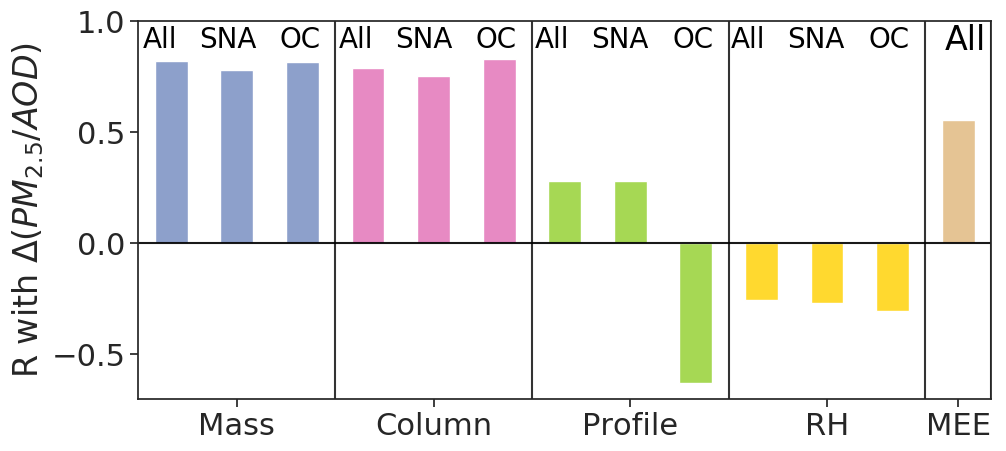

In [64]:
value = r_pm_aod
# value[4]  = -1*value[4] 
sns.set(color_codes=True, font_scale = 2)
color_arr_all = []
for iv in color_arr_sub[0:4]:
    for ic in range(0,3):
        color_arr_all.append(iv)
color_arr_all.append(color_arr[6])
color_arr_all.append(color_arr[7])


# df_pm_all[var_name].boxplot()
# sns.set(color_codes=True, font_scale = 1.18)
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
fig, ax = plt.subplots(figsize=(11, 5), dpi = 100)
df = pd.DataFrame({'Var':['Mass','SULF','OC','Column_TOT','Column_SULF','Column_OC','Profile','Profile_SULF','Profile_OC','MEE','RH','RH_SULF','RH_OC'], 'R':value})
df.plot.bar(ax = ax, x='Var', y='R', rot=0, color = color_arr_all)
ax.set_xlabel('')
ax.set_ylabel('R with $\Delta  (PM_{2.5}/AOD$)')
ax.legend_.remove()
ax.set_ylim(-0.7, 1.0)
ax.axhline(0, color='black',alpha = 0.9)

x = [1, 4, 7, 10, 12]
labels = ['Mass', 'Column','Profile','RH','MEE']

plt.xticks(x, labels)

ax.tick_params(which='minor', length=4, color='r')

for i in range(0,4):
    ax.text(0.025+i*0.23, 0.95,'All', ha='center', va='center', transform=ax.transAxes, color = 'black', fontsize = 20)
    ax.text(0.105+i*0.23, 0.95,'SNA', ha='center', va='center', transform=ax.transAxes, color = 'black', fontsize = 20)
    ax.text(0.190+i*0.23, 0.95,'OC', ha='center', va='center', transform=ax.transAxes, color = 'black', fontsize = 20)

ax.text(0.11+4*0.215, 0.95,'All', ha='center', va='center', transform=ax.transAxes, color = 'black')

ax.axvline(12.5, color='black',alpha = 0.8)
ax.axvline(11.5, color='black',alpha = 0.8)
ax.axvline(8.5, color='black',alpha = 0.8)
ax.axvline(5.5, color='black',alpha = 0.8)
ax.axvline(2.5, color='black',alpha = 0.8)
